# The Power of Multitask Learning

A simple demonstration of the power of multi-task learning (MTL) compared to single-task learning (STL) approaches.

---

## Navigation

1. [Get Data](#Get-Data)
1. [Preprocessing](#Preprocessing)
1. [Modeling](#Modeling)
1. [Visualizations](#Visualizations)

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from plotnine import *
from cycler import cycler
import matplotlib as mpl

%matplotlib inline


plt.style.use("ggplot")
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000"])
plt.rcParams.update({
    "figure.figsize": (5, 3),
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "legend.title_fontsize": 12,
})

pd.set_option("max_colwidth", 100)

In [8]:
%%capture
!pip install bq_helper
!pip install celluloid

## Get Data

We use the [Chicago Taxicabs dataset](https://www.kaggle.com/chicago/chicago-taxi-trips-bq) which includes taxi trips from 2013 to mid. 2017, reported to the City of Chicago. </br>This dataset is publicly available for anyone to use under the following terms provided by the Dataset Source - https://data.cityofchicago.org.

In [5]:
#load google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject/codes/radss-master/notebooks/'


''' NOTE: We run this section of code via Kaggle and downloaded
the queried data
'''

#from bq_helper.py import *
#from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
# chicago_taxi = BigQueryHelper(
#     active_project="bigquery-public-data",
#     dataset_name="chicago_taxi_trips"
# )

# companies = (
#     'Blue Ribbon Taxi Association Inc.',
#     'Choice Taxi Association',
#     'Dispatch Taxi Affiliation',
#     'Northwest Management LLC'
# )
# end_date = '2017-01-01'

# qry = \
# f"""
# SELECT EXTRACT(date FROM trip_start_timestamp) AS ds
#        ,company as task
#        ,COUNT(1) AS num_rides
# FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
# WHERE 1=1
#     AND company in {companies}
#     AND EXTRACT(date FROM trip_start_timestamp) <= '{end_date}'
# GROUP BY 1,2
# ORDER BY 2,1
# """
# data = chicago_taxi.query_to_pandas_safe(qry, max_gb_scanned=20)
# data.ds = pd.to_datetime(data.ds)
# data.head()

Mounted at /content/drive


' NOTE: We run this section of code via Kaggle and downloaded\nthe queried data\n'

In [41]:
data = pd.read_csv(f'{DIR}Chicago_Taxi.csv', index_col=0)
data.ds = pd.to_datetime(data.ds)
data.head()

,ds,task,num_rides
0,2013-01-01,Blue Ribbon Taxi Association Inc.,4623
1,2013-01-02,Blue Ribbon Taxi Association Inc.,2632
2,2013-01-03,Blue Ribbon Taxi Association Inc.,2806
3,2013-01-04,Blue Ribbon Taxi Association Inc.,3463
4,2013-01-05,Blue Ribbon Taxi Association Inc.,3558


In [42]:
def plot_tasks(data, y='num_rides'):
    fig, ax = plt.subplots()#figsize=(15, 8))

    # unique tasks
    tasks = data.task.unique()
    n_tasks = len(tasks)

    # color map
    cmap = plt.get_cmap('magma', n_tasks+2)
    ax.set_prop_cycle(color=cmap.colors[range(1, n_tasks+1)])

    # plot
    for i, task in enumerate(tasks):
        # curr task
        task_data = data.loc[data.task == task].copy()

        ax.plot_date(
            task_data.ds,
            task_data[y],
            '-',
            alpha=1.
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return fig

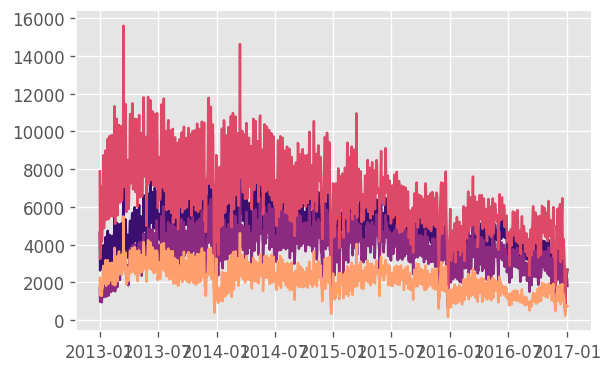

In [43]:
fig = plot_tasks(data)

## Preprocessing

### Scaling

   - Take $\log$
   - Divide by the maximal response value

In [49]:
data.sort_values(['task', 'ds'], inplace=True)
display (data.head)


data = data.assign(
    scaled_num_rides = (data.groupby('task').num_rides.apply(
        lambda x : np.log(x) / np.log(x).max()).reset_index(drop=True)
    )
)

data

<bound method NDFrame.head of              ds                               task  num_rides  \
0    2013-01-01  Blue Ribbon Taxi Association Inc.       4623   
1    2013-01-02  Blue Ribbon Taxi Association Inc.       2632   
2    2013-01-03  Blue Ribbon Taxi Association Inc.       2806   
3    2013-01-04  Blue Ribbon Taxi Association Inc.       3463   
4    2013-01-05  Blue Ribbon Taxi Association Inc.       3558   
...         ...                                ...        ...   
5843 2016-12-28           Northwest Management LLC        664   
5844 2016-12-29           Northwest Management LLC        723   
5845 2016-12-30           Northwest Management LLC        775   
5846 2016-12-31           Northwest Management LLC        708   
5847 2017-01-01           Northwest Management LLC        744   

      scaled_num_rides  
0             0.919075  
1             0.857726  
2             0.864698  
3             0.887610  
4             0.890557  
...                ...  
5843          0.754677  
5844          0.764563  
5845          0.772629  
5846          0.762128  
5847          0.767888  

[5848 rows x 4 columns]>

,ds,task,num_rides,scaled_num_rides
0,2013-01-01,Blue Ribbon Taxi Association Inc.,4623,0.919075
1,2013-01-02,Blue Ribbon Taxi Association Inc.,2632,0.857726
2,2013-01-03,Blue Ribbon Taxi Association Inc.,2806,0.864698
3,2013-01-04,Blue Ribbon Taxi Association Inc.,3463,0.887610
4,2013-01-05,Blue Ribbon Taxi Association Inc.,3558,0.890557
...,...,...,...,...
5843,2016-12-28,Northwest Management LLC,664,0.754677
5844,2016-12-29,Northwest Management LLC,723,0.764563
5845,2016-12-30,Northwest Management LLC,775,0.772629
5846,2016-12-31,Northwest Management LLC,708,0.762128


In [50]:
# Y df
Y_df = data.pivot_table(
    index='ds',
    columns='task',
    values='scaled_num_rides'
)

# to matrix
Y = Y_df.values
Y.shape

(1462, 4)

Let's look at the scaled data:

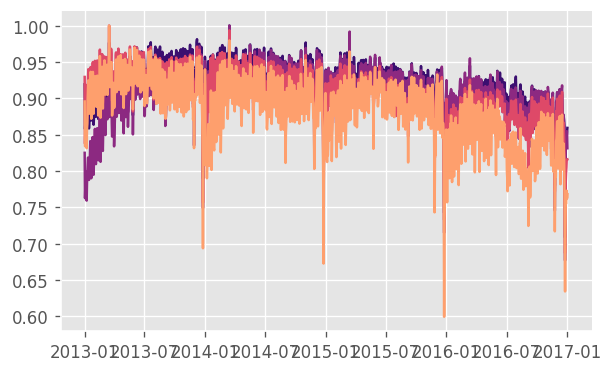

In [52]:
fig = plot_tasks(data, 'scaled_num_rides')
#fig.savefig("../images/mtl-scaled-w-axes.png")

### $X$ Matrix

We utilize the Fourier series to model our data. For details, see:
1. [Sean J. Taylor, Benjamin Letham (2018) Forecasting at scale. The American Statistician 72(1):37-45](https://peerj.com/preprints/3190.pdf).
1. Harvey, A. C. & Shephard, N. (1993), Structural time series models, in G. Maddala, C. Rao
& H. Vinod, eds, ‘Handbook of Statistics’, Vol. 11, Elsevier, chapter 10, pp. 261–302.

Also, you can use the awesome [Prophet](https://github.com/facebook/prophet) package by Facebook.

In [75]:
# From: https://github.com/facebook/prophet/blob/master/python/fbprophet/forecaster.py#L373

from datetime import datetime
epoch = pd.to_datetime('2010-01-01')

def fourier_series(dates, period, series_order, epoch=epoch):
        # convert to days since epoch
        t = (dates - epoch).dt.days

        return np.column_stack(
            [
                fun((2.0 * (i + 1) * np.pi * t / period))
                for i in range(series_order)
                for fun in (np.sin, np.cos)
            ]
        )

In [76]:
dates = data.ds.sort_values().drop_duplicates()

# changepoints matrix (for piecewise linear trend)
n_changepoints = 30
t = (dates - epoch).dt.days

cp = [
    (t.size // n_changepoints) * x
    for x in range(n_changepoints)
]

X_cp = np.zeros((t.shape[0], n_changepoints))
t_scale = t / t.max()

for i, cpoint in enumerate(cp):
    X_cp[cpoint:, i] = t_scale[cpoint:]

In [77]:
X_seasonality = np.concatenate(
    [
        fourier_series(dates, period, series_order=10)
        for period in [7, 365.25]
    ], axis=1
)

In [81]:
fourier_series(dates, period=7, series_order=10)[0]
dates, epoch, (dates - epoch)#.dt.days
data.ds.sort_values().drop_duplicates()

,ds
0,2013-01-01
1,2013-01-02
2926,2013-01-03
4389,2013-01-04
2928,2013-01-05
...,...
5843,2016-12-28
4382,2016-12-29
4383,2016-12-30
4384,2016-12-31


In [82]:
X = np.concatenate((X_seasonality, X_cp), axis=1)

## Modeling

   - Single task lasso
   - Group lasso

In [83]:
class stlLasso():
    """
    Simple implementation of STL Lasso
    """
    def __init__(self, **kwargs):
        self.params = kwargs

        self.models = None
        self.coef_ = None

    def fit(self, X, Y):
        self.models = [
            LassoCV(**self.params).fit(X, Y[:,i])
            for i in range(Y.shape[1])
        ]

        self.coef_ = np.stack([
            mod.coef_
            for mod in self.models
        ])

        return self

    def predict(self, X):
        return np.column_stack(
            [
                model.predict(X)
                for model in self.models
            ]
        )

We will measure performance with MSE, using Simulated Historical Forecasts (SHF) for producing $K$ forecasts at various cutoff points in the history ([Sean J. Taylor, Benjamin Letham (2018) Forecasting at scale. The American Statistician 72(1):37-45](https://peerj.com/preprints/3190.pdf)).

In [85]:
n_test = 7
train_pct = .85
train_size = int(Y_df.shape[0] * train_pct)

cutoffs = np.arange(train_size, Y_df.shape[0], n_test)
len(cutoffs)

32

In [118]:
Y.shape

(1462, 4)

In [99]:
def evaluate(
    cutoff=0,
    loss=mean_squared_error,
    max_iter=1000):

    res = []
    stl_preds = []
    mtl_preds = []

    for i, cutoff in enumerate(cutoffs):
        print(f'\rRunning cutoff {i+1} out of {len(cutoffs)}.', end='')

        # MTL
        #m = MultiTaskLassoCV(normalize=True, max_iter=max_iter).fit(X[:cutoff,], Y[:cutoff,])
        m = MultiTaskLassoCV(max_iter=max_iter).fit(X[:cutoff,], Y[:cutoff,])

        Y_pred_mtl = m.predict(X[cutoff:cutoff+n_test])

        # STL
        #sl = stlLasso(normalize=True, max_iter=max_iter)
        sl = stlLasso(max_iter=max_iter)

        sl.fit(X[:cutoff,], Y[:cutoff,])
        Y_pred_stl = sl.predict(X[cutoff:cutoff+n_test])

        # results
        res.append(
            {
                'mtl_error':loss(Y[cutoff:cutoff+n_test], Y_pred_mtl),
                'stl_error':loss(Y[cutoff:cutoff+n_test], Y_pred_stl)
            }
        )

        stl_preds.append(Y_pred_stl)
        mtl_preds.append(Y_pred_mtl)

    return res, stl_preds, mtl_preds

In [100]:
%%time
res, stl_preds, mtl_preds = evaluate()

Running cutoff 32 out of 32.CPU times: user 6min 7s, sys: 629 ms, total: 6min 7s
Wall time: 5min 17s


In [104]:
pd.DataFrame(res).tail()

,mtl_error,stl_error
27,0.000196,0.000195
28,0.000522,0.000506
29,0.000377,0.000336
30,0.005769,0.006227
31,0.000164,0.000220


In [ ]:
print(f'MSE improvement {pd.DataFrame(res).mean().pct_change().values[1]*100:.2f}%')

MSE improvement 2.24%


## Visualization

Visualization for blog post.

In [105]:
from celluloid import Camera

### TS

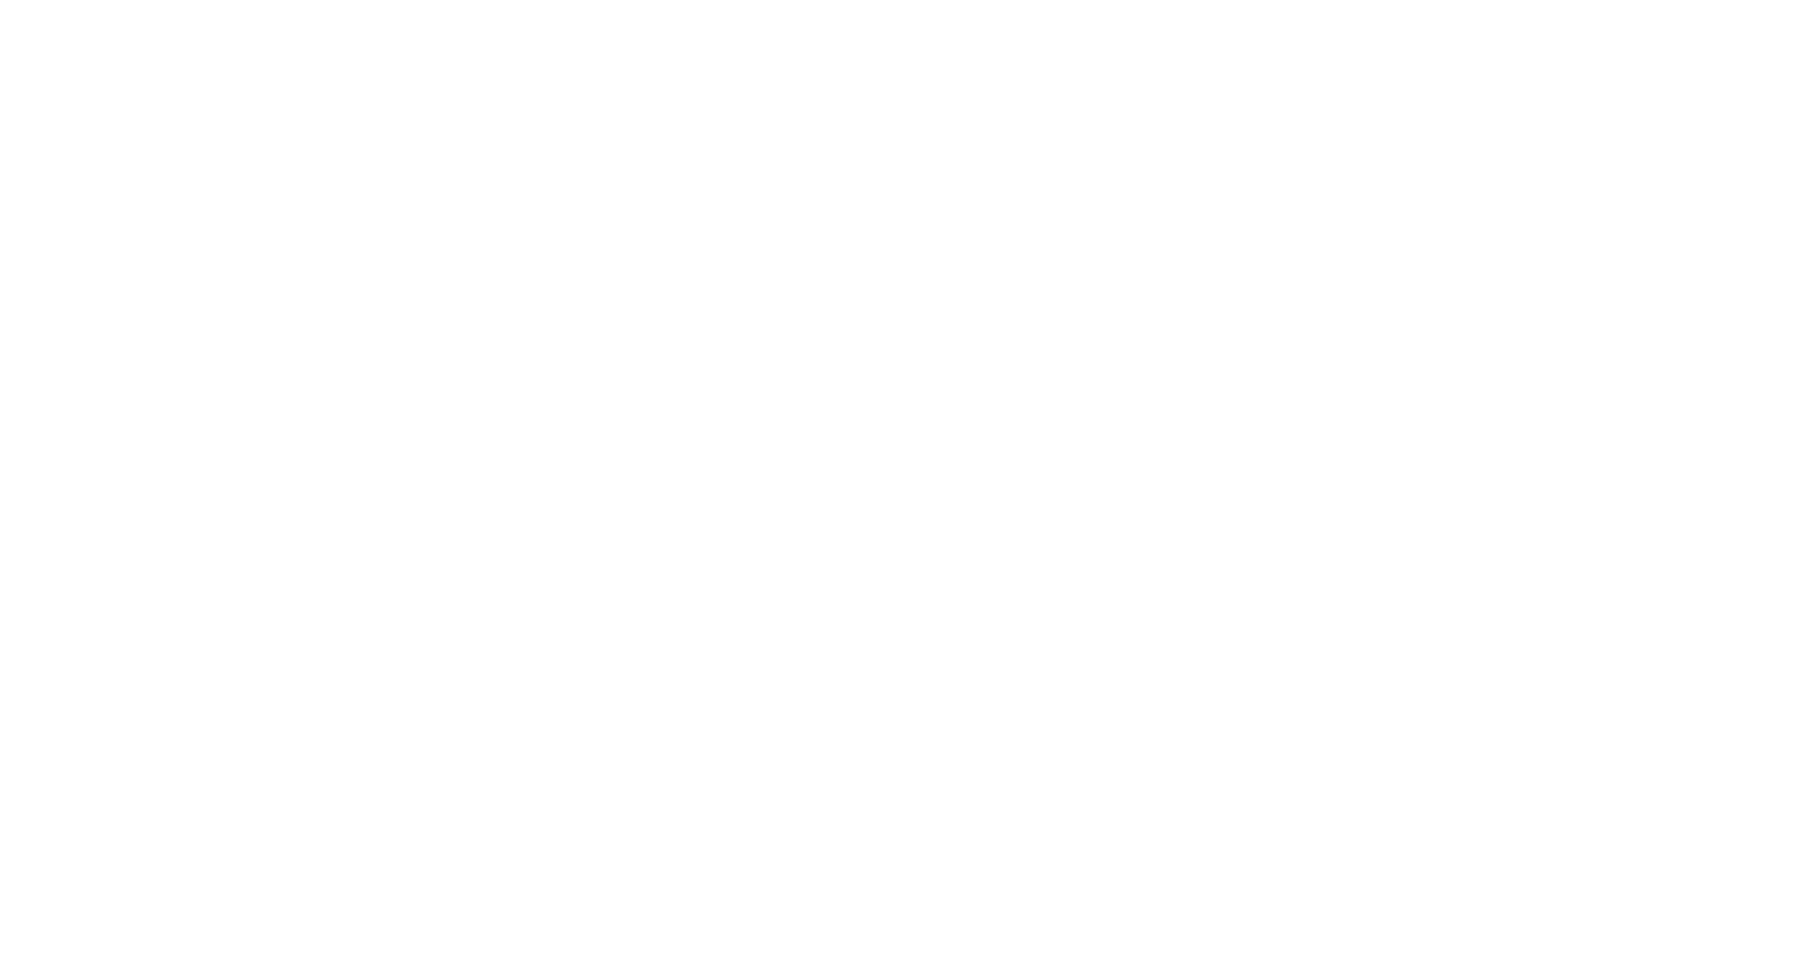

In [109]:
fig, ax = plt.subplots(figsize=(15, 8))

camera = Camera(fig)

# unique tasks
tasks = data.task.unique()
n_tasks = len(tasks)

# color map
cmap = plt.get_cmap('magma', n_tasks+2)
ax.set_prop_cycle(color=cmap.colors[range(1, n_tasks+1)])

# plot
for i, task in enumerate(tasks):
    # curr task
    task_data = data.loc[data.task == task].copy()

    plt.plot_date(
        task_data.ds,
        task_data.scaled_num_rides,
        '-',
        alpha=1.
    )
    plt.axis('off')
    camera.snap()

animation = camera.animate()
animation.save(f'{DIR}images/mtl-ts.gif', writer = 'imagemagick', fps=1)

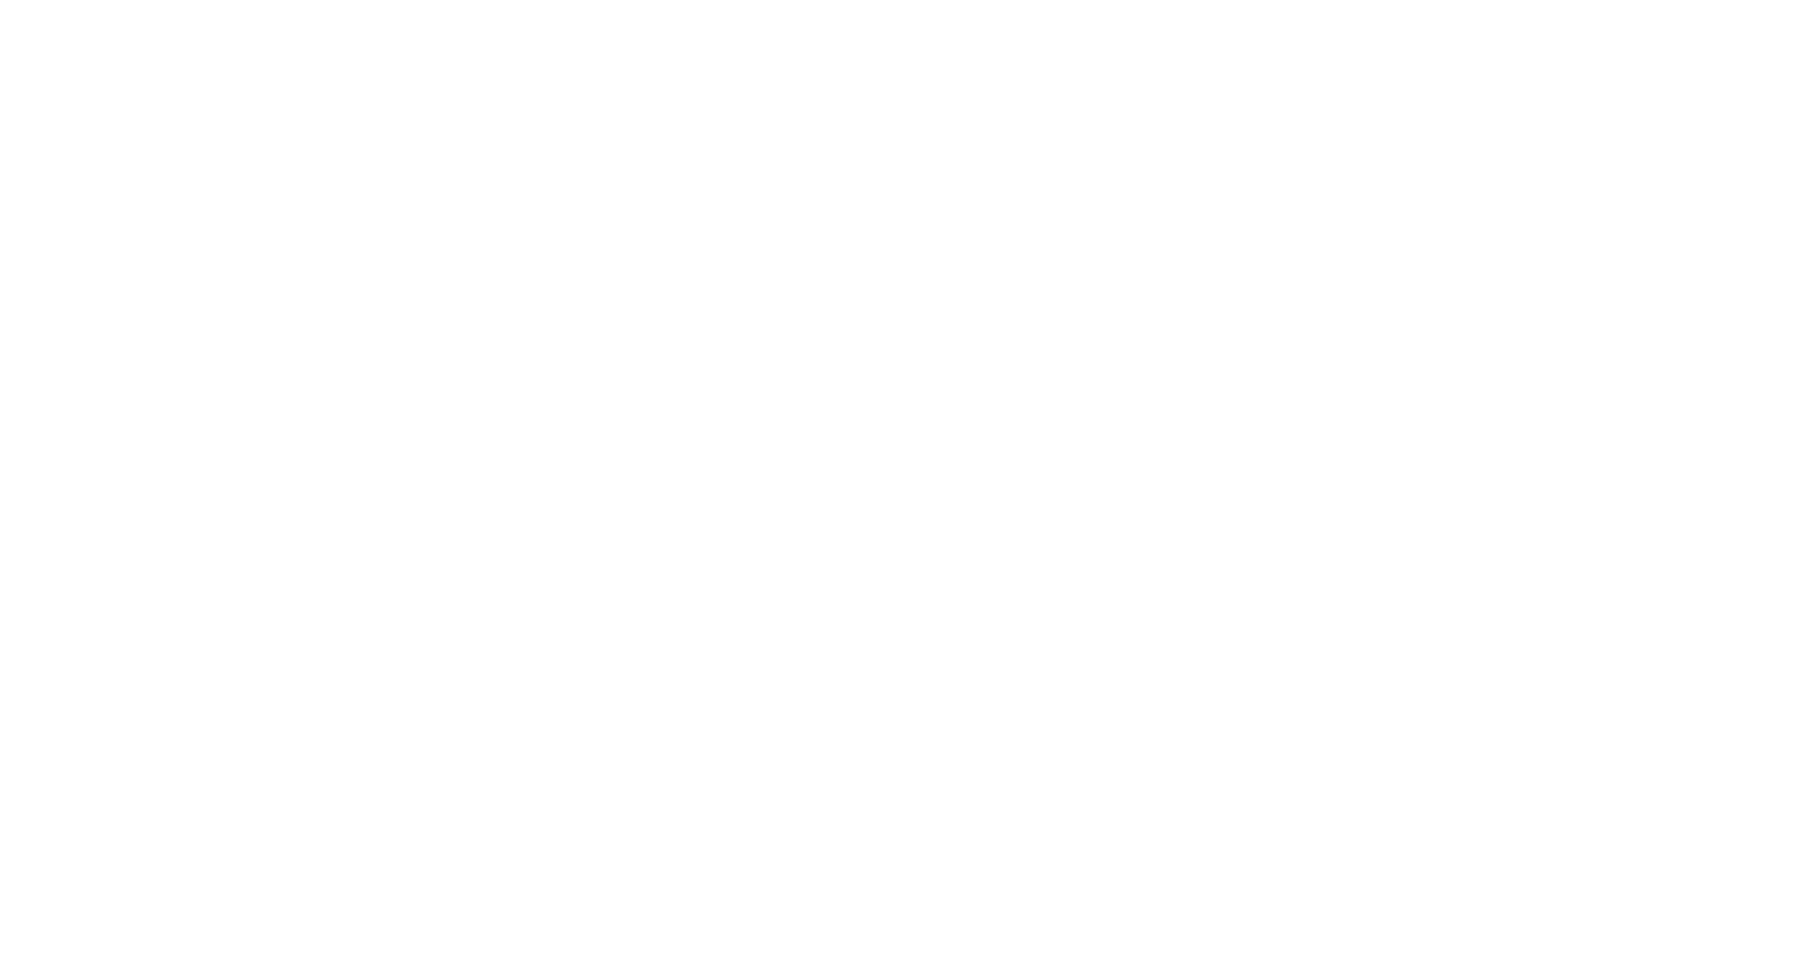

In [110]:
fig, ax = plt.subplots(figsize=(15, 8))

camera = Camera(fig)

# unique tasks
tasks = data.task.unique()
n_tasks = len(tasks)

# color map
cmap = plt.get_cmap('magma', n_tasks+2)
#ax.set_prop_cycle(color=cmap.colors[range(1, n_tasks+1)])

# plot
for j in range(1, len(tasks)+1):
    # color map
    ax.set_prop_cycle(color=cmap.colors[range(1, 1+j)])

    for i, task in enumerate(tasks[:j]):
        # curr task
        task_data = data.loc[data.task == task].copy()

        ax.plot_date(
            task_data.ds,
            task_data.scaled_num_rides,
            '-',
            alpha=1.
        )
        ax.axis('off')

    camera.snap()

animation = camera.animate()
animation.save(f'{DIR}images/mtl-ts-add.gif', writer = 'imagemagick', fps=1)

### Sparsity Structure

In [111]:
from matplotlib.colors import ListedColormap

In [113]:
n_train_for_plot = 1500

#mtl_mat = MultiTaskLassoCV(normalize=True, max_iter=10000).fit(X[:n_train_for_plot], Y[:n_train_for_plot]).coef_
#stl_mat = stlLasso(normalize=True, max_iter=10000).fit(X[:n_train_for_plot], Y[:n_train_for_plot]).coef_

mtl_mat = MultiTaskLassoCV(max_iter=10000).fit(X[:n_train_for_plot], Y[:n_train_for_plot]).coef_
stl_mat = stlLasso(max_iter=10000).fit(X[:n_train_for_plot], Y[:n_train_for_plot]).coef_

In [114]:
# colors
cmap = plt.get_cmap('magma', 256)
newcolors = cmap([.55, .95])
newcolors = ListedColormap(newcolors)

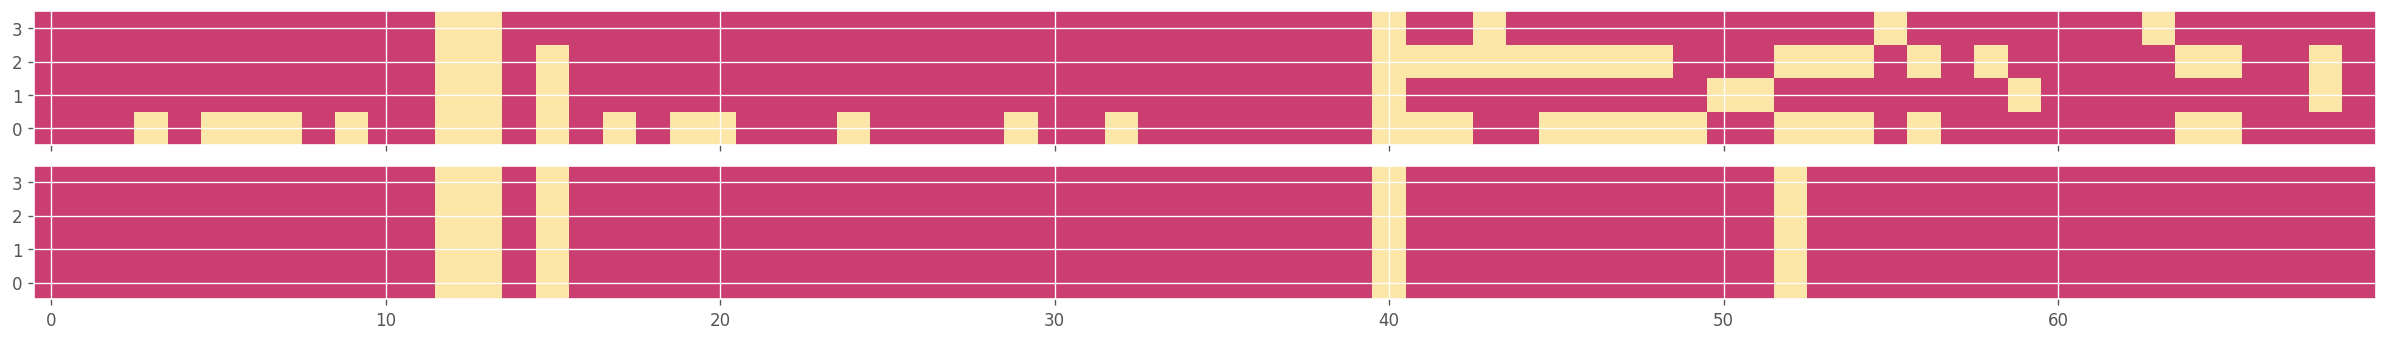

In [115]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 3), sharex=True, sharey=True)
matplot = ax1.imshow(np.where((stl_mat == 0), 1., .0), origin='lower', cmap=newcolors)
matplot = ax2.imshow(np.where((mtl_mat == 0), 1., .0), origin='lower', cmap=newcolors)
fig.tight_layout();

In [ ]:
fig.savefig('../images/sparsity_structure.png')

### SHF

In [ ]:
to_plot = pd.DataFrame(
    np.concatenate(stl_preds),
    index=Y_df.iloc[train_size:].index,
    columns=Y_df.columns
)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

# axes
ax.set_xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2017-01-10'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

camera = Camera(fig)

# color map
cmap = plt.get_cmap('magma', (len(cutoffs)+1))

# task
task = 'Dispatch Taxi Affiliation'

for n_lines, i in enumerate(range(0, len(cutoffs)*7, 7)):
    plt.axvline(Y_df.iloc[train_size:].index[i], linestyle='--', c='k')

    # colors
    ax.set_prop_cycle(color=cmap.colors[:(n_lines+2)])

    # full ts
    ax.plot_date(Y_df.index, Y_df[task], '-', alpha=.5)

    for j in range(0, i+7, 7):
        # shf
        ax.plot_date(
            to_plot.index[j:j+7],
            to_plot[task].values[j:j+7],
            '-'
        )

    camera.snap()

animation = camera.animate()
animation.save('../images/mtl-shf-moving-hline.gif', writer = 'imagemagick', fps=3)

In [ ]:
from google.colab import auth

# Authenticate with Google Cloud
auth.authenticate_user()
print('Authenticated')